In [52]:
import pandas as pd
import datetime as dt
import numpy as np
import glob
import re

holidays = [dt.date(2020,12,31),dt.date(2021,1,1),dt.date(2021,1,2), dt.date(2021,1,3), dt.date(2021,1,4), dt.date(2021,1,5), 
            dt.date(2021,1,6), dt.date(2021,1,7), dt.date(2021,1,8), dt.date(2021,1,9), dt.date(2021,1,10), dt.date(2021,2,22),
            dt.date(2021,2,23), dt.date(2021,3,8), dt.date(2021,5,3),dt.date(2021,5,4), dt.date(2021,5,5), dt.date(2021,5,6), 
            dt.date(2021,5,7), dt.date(2021,5,10), dt.date(2021,11,4), dt.date(2021,11,5)]
   

def preprocess_dataframe(dataframe):
    dataframe['Время звонка']=dataframe['Время звонка'].astype('str')
    dataframe['Время ожидания']=pd.to_timedelta(dataframe['Время ожидания'].astype('str'))
    dataframe['Время разговора']=pd.to_timedelta(dataframe['Время разговора'].astype('str'))
    
    dataframe=dataframe.groupby((dataframe[['Номер телефона']].isnull()==False).all(1).cumsum()).agg({'Время звонка': ' '.join, 'Номер телефона': 'first', 'Статус звонка': 'first',
                  'Время ожидания': 'first', 'Время разговора': 'first',
                  'Группа': 'first', 'Оператор': 'first'})
    
    dataframe['Время звонка']=dataframe['Время звонка'].apply(lambda x: dt.datetime.strptime(x, '%H:%M:%S %Y-%m-%d 00:00:00'))
    dataframe['Дата звонка']=dataframe['Время звонка'].dt.date
    dataframe['День недели']=dataframe['Время звонка'].apply(lambda x: x.weekday())
    dataframe['Час звонка']=dataframe['Время звонка'].dt.hour
    dataframe['Время звонка']=dataframe['Время звонка'].dt.time
    
    dataframe['Время ожидания']=dataframe['Время ожидания'].apply(lambda x: x.total_seconds()/60)
    dataframe['Время разговора']=dataframe['Время разговора'].apply(lambda x: x.total_seconds()/60)
    
    dataframe['Оператор']= dataframe['Оператор'].replace({np.nan:None})
    dataframe['Отчетная дата'] = dataframe['Дата звонка'] + dt.timedelta(days=1) 
    return dataframe


def table_waiting_time(total):
    total['Ждали']=total['Время ожидания'].apply(lambda x: x*60)
    total['Ждали']= total.apply(lambda row: row['Ждали'], axis=1)
    total['Время ожидания звонка']=total['Ждали'].apply(lambda x: dt.time(int(x/3600), int((x-int(x/3600)*3600)/60), int(x-int(x/60)*60)))
    #table = total_all_days.sort_values(by='Время ожидания', ascending=False)[['Дата звонка','Время звонка','Время ожидания звонка', 'Группа', 'Оператор', 'Статус звонка']].copy()
    table = total.sort_values(by='Время ожидания', ascending=False).loc[:,('Дата звонка','Время звонка','Время ожидания звонка', 'Группа', 'Оператор', 'Статус звонка')]
    print(table)
    return table

def table_waiting_time2(total_all_days):
    total_all_days['Ждали']=total_all_days['Время ожидания'].apply(lambda x: x*60)
    total_all_days['Ждали']= total_all_days.apply(lambda row: row['Ждали'], axis=1)
    total_all_days['Время ожидания звонка']=total_all_days['Ждали'].apply(lambda x: dt.time(int(x/3600), int((x-int(x/3600)*3600)/60), int(x-int(x/60)*60)))
    #table = total_all_days.sort_values(by='Время ожидания', ascending=False)[['Дата звонка','Время звонка','Время ожидания звонка', 'Группа', 'Оператор', 'Статус звонка']].copy()
    table = total_all_days.sort_values(by='Время ожидания', ascending=False).loc[:,('Дата звонка','Время звонка','Время ожидания звонка', 'Группа', 'Оператор', 'Статус звонка')]
    return table

# -
def calculate_statistics(dataframe, title):
    reporting_date = dataframe['Дата звонка'].values[0]
    
    day = dataframe[(dataframe['Час звонка'] >=8 ) & (dataframe['Час звонка']  < 20)]
    night = dataframe[(dataframe['Час звонка'] < 8) | (dataframe['Час звонка'] >= 20)]
    oper_df=dataframe[(dataframe['Оператор'].notna()) & (dataframe['Оператор']!='--')]

    # Рассчитываем количество операторов в рабочее время (c 8:00 по 20:00)
    work_day_df = oper_df[(oper_df['Час звонка']>=8) & (oper_df['Час звонка'] < 20)]
    all_oper_day = len(work_day_df['Оператор'].unique())
    oper_day=len(work_day_df[work_day_df['Статус звонка']!='Не дождался'] ['Оператор'].unique())

    # Рассчитываем количество операторов в НЕ рабочее время
    not_work_day_df = oper_df[(oper_df['Час звонка'] < 8) | (oper_df['Час звонка'] >= 20)]
    all_oper_night = len(not_work_day_df['Оператор'].unique())
    oper_night=len(not_work_day_df[not_work_day_df['Статус звонка']!='Не дождался'] ['Оператор'].unique())
    all_oper = len(oper_df['Оператор'].unique())


    # Рассчитываем количество званков всего
    all_calls = dataframe.shape[0]
    # Рассчитываем количество званков ночью
    all_night_calls = night.shape[0]
    # Рассчитываем количество званков днём
    all_work_day_calls = day.shape[0]


    # Рассчитываем количество пропущенных всего званков
    all_missed_calls=dataframe[dataframe["Статус звонка"]=='Не дождался'].shape[0]
    # Рассчитываем количество пропущенных званков днём
    day_missed_calls = day[day["Статус звонка"]=='Не дождался'].shape[0]
    # Рассчитываем количество пропущенных званков ночью
    night_missed_calls = night[night["Статус звонка"]=='Не дождался'].shape[0]


    # Рассчитываем среднее время разговора за сутки
    mean_talk=np.round(dataframe['Время разговора'].mean(),1)
    # Рассчитываем среднее время разговора за день
    day_mean_talk=np.round(day['Время разговора'].mean(),1)
    # Рассчитываем среднее время разговора за ночь
    night_mean_talk = np.round(night['Время разговора'].mean(),1)


    # Рассчитываем максимальнок время ожидание
    max_wait_df = dataframe[dataframe['Время ожидания']==dataframe['Время ожидания'].max()]
    # За сутки
    max_wait=np.round(dataframe['Время ожидания'].max(),1)
    time_with_max_wait = max_wait_df['Время звонка'].values[0]
    # За день
    max_wait_day_df = day[day['Время ожидания']==day['Время ожидания'].max()]
    max_wait_day = np.round(day['Время ожидания'].max(),1)
    time_with_max_wait_day = max_wait_day_df['Время звонка'].values[0]
    # За ночь
    max_wait_night_df = night[night['Время ожидания'] == night['Время ожидания'].max()]
    max_wait_night = np.round(night['Время ожидания'].max(),1)    
    time_with_max_wait_night =  0 if max_wait_night_df.empty else max_wait_night_df['Время звонка'].values[0]    
    
    
    # Рассчитываем у какого оператора было максимальнок время ожидание и в какой он группе
    # За сутки
    group_with_max_wait = max_wait_df['Группа'].values[0]
    oper__with_max_wait = max_wait_df['Оператор'].values[0]
    # За день
    group_with_max_wait_day = max_wait_day_df['Группа'].values[0]
    oper__with_max_wait_day = max_wait_day_df['Оператор'].values[0]
    # За ночь
    group_with_max_wait_night = 0 if max_wait_night_df.empty else max_wait_night_df['Группа'].values[0]
    oper__with_max_wait_night = 0 if max_wait_night_df.empty else max_wait_night_df['Оператор'].values[0]
    
    
    # Рассчитываем среднее время ожидание
    all_wait = dataframe['Время ожидания']
    day_wait = day['Время ожидания']
    night_wait = night['Время ожидания']
    # За сутки
    mean_wait = np.round(all_wait.mean(),5)
    # За день
    mean_wait_day = np.round(day_wait.mean(),5)
    # За ночь
    mean_wait_night = np.round(night_wait.mean(),5)

    # Рассчитываем ожидание более 3 минут
    # За сутки
    more_3_min_df = dataframe[all_wait >= 3].shape[0]
    more_3_min = np.round(more_3_min_df * 100 / all_calls, 0)
    # За день
    more_3_min_day_df = day_wait[day_wait >= 3].shape[0]
    more_3_min_day = np.round(more_3_min_day_df * 100 / all_calls, 0)
    # За ночь
    more_3_min_night_df = night_wait[night_wait >= 3].shape[0]
    more_3_min_night = np.round(more_3_min_df * 100 / all_calls, 0)

    # За сутки
    print(f'{title}\nза {reporting_date}\n')
    print('Информация за сутки: \n')
    print(f'Число операторов всего: {all_oper},\nВсего звонков {all_calls}, неотвеченных вызовов: {all_missed_calls}')
    print(f'Среднее время разговора за сутки (мин): {mean_talk}')
    print(f'Максимальное время ожидания за сутки (мин): {max_wait} (Оператор: {oper__with_max_wait}, Группа: {group_with_max_wait}, Время звонка: {time_with_max_wait})')
    print(f'Среднее время ожидания за сутки(мин): {mean_wait}')
    print(f'Ожидание более 3 минут за сутки (%): {more_3_min}\n')

    # За день
    print('\nИнформация за рабочий день (с 8:00 до 20:00): \n')
    print(f'Число операторов днем {all_oper_day}, из них {oper_day} отвечали на звонки')
    print(f'Днем позвонили {all_work_day_calls} раз, из них неотвеченных вызовов: {day_missed_calls}')
    print(f'Среднее время разговора денём (мин): {day_mean_talk}')
    print(f'Максимальное время ожидания днём (мин): {max_wait_day} (Оператор: {oper__with_max_wait_day}, Группа: {group_with_max_wait_day}, Время звонка: {time_with_max_wait_day})')
    print(f'Среднее время ожидания днём (мин): {mean_wait_day}')
    print(f'Ожидание более 3 минут днём (%): {more_3_min_day}\n')

    # За ночь
    print('\nИнформация за ночь (с 00:00 до 8:00 и с 20:00 до 00:00): \n')
    print(f'Число операторов ночью {all_oper_night}, из них {oper_night} отвечали на звонки')
    print(f'Ночью позвонили {all_night_calls} раз, из них неотвеченных вызовов: {night_missed_calls}')      
    print(f'Среднее время разговора ночью (мин): {night_mean_talk}')
    print(f'Максимальное время ожидания ночью (мин): {max_wait_night} (Оператор: {oper__with_max_wait_night}, Группа: {group_with_max_wait_night}, Время звонка: {time_with_max_wait_night})')    
    print(f'Среднее время ожидания ночью (мин): {mean_wait_night}')
    print(f'Ожидание более 3 минут ночью (%): {more_3_min_night}')


def create_df(names):
    cont = []
    for i in range(len(names)):
        if names[i] =='../Недозвоны/ВМК1\~$2022-03-02.xlsx':
            continue
#         print(names[i])
        df = pd.read_excel(names[i], engine='openpyxl')
        df=preprocess_dataframe(df)

        cont.append(df)
    return pd.concat(cont)
    
names= glob.glob('../Недозвоны/ВМК/*', recursive=True)
names2= glob.glob('../Недозвоны/ВМК2/*', recursive=True)

total_all_days = create_df(names)
total_all_days['Группа']=total_all_days['Группа'].replace({'Общая':'Медколледж','group':'Облкомобразования','Консультация':'Облкомобразования'})

total_all_days2 = create_df(names2)
total_all_days2['Группа']=total_all_days2['Группа'].replace({'Общая':'Медколледж','group':'Облкомобразования','Консультация':'Облкомобразования'})


# Выбор отчётной даты

In [53]:
#day=dt.date.today()
day=dt.date(2022,3,31)

# Создаём датафрейм для первого домена
df_specific_day = total_all_days[total_all_days['Дата звонка']==day].copy()
reporting_date = df_specific_day['Дата звонка'].values[0]


### Считаем статистику по первому домену

In [54]:
calculate_statistics(df_specific_day,'Данные по первому домену')

Данные по первому домену
за 2022-03-31

Информация за сутки: 

Число операторов всего: 20,
Всего звонков 285, неотвеченных вызовов: 7
Среднее время разговора за сутки (мин): 1.0
Максимальное время ожидания за сутки (мин): 0.8 (Оператор: user109, Группа: Медколледж, Время звонка: 11:17:31)
Среднее время ожидания за сутки(мин): 0.12105
Ожидание более 3 минут за сутки (%): 0.0


Информация за рабочий день (с 8:00 до 20:00): 

Число операторов днем 20, из них 20 отвечали на звонки
Днем позвонили 285 раз, из них неотвеченных вызовов: 7
Среднее время разговора денём (мин): 1.0
Максимальное время ожидания днём (мин): 0.8 (Оператор: user109, Группа: Медколледж, Время звонка: 11:17:31)
Среднее время ожидания днём (мин): 0.12105
Ожидание более 3 минут днём (%): 0.0


Информация за ночь (с 00:00 до 8:00 и с 20:00 до 00:00): 

Число операторов ночью 0, из них 0 отвечали на звонки
Ночью позвонили 0 раз, из них неотвеченных вызовов: 0
Среднее время разговора ночью (мин): nan
Максимальное время ожида

### Таблица максимального времени ожидания за конктретную дату

In [55]:
table_waiting_time(df_specific_day).head(20)

    Дата звонка Время звонка Время ожидания звонка      Группа Оператор  \
127  2022-03-31     11:17:31              00:00:50  Медколледж  user109   
123  2022-03-31     11:06:31              00:00:46  Медколледж   user82   
132  2022-03-31     11:23:51              00:00:44  Медколледж  user111   
134  2022-03-31     11:27:07              00:00:43  Медколледж  user113   
125  2022-03-31     11:11:49              00:00:39  Медколледж  user108   
..          ...          ...                   ...         ...      ...   
37   2022-03-31     09:15:16              00:00:02  Медколледж   user86   
21   2022-03-31     09:06:07              00:00:02  Медколледж   user86   
54   2022-03-31     09:31:01              00:00:02  Медколледж   user86   
180  2022-03-31     12:56:56              00:00:01  Медколледж  user112   
52   2022-03-31     09:26:49              00:00:00  Медколледж   user86   

    Статус звонка  
127     Переведён  
123     Переведён  
132     Переведён  
134     Переведён  

,Дата звонка,Время звонка,Время ожидания звонка,Группа,Оператор,Статус звонка
127,2022-03-31,11:17:31,00:00:50,Медколледж,user109,Переведён
123,2022-03-31,11:06:31,00:00:46,Медколледж,user82,Переведён
132,2022-03-31,11:23:51,00:00:44,Медколледж,user111,Переведён
134,2022-03-31,11:27:07,00:00:43,Медколледж,user113,Переведён
125,2022-03-31,11:11:49,00:00:39,Медколледж,user108,Не дождался
181,2022-03-31,12:59:07,00:00:33,Медколледж,user112,Переведён
135,2022-03-31,11:31:07,00:00:25,Медколледж,user108,Переведён
130,2022-03-31,11:21:58,00:00:25,Медколледж,user108,Не дождался
240,2022-03-31,15:33:47,00:00:22,Медколледж,user110,Переведён
244,2022-03-31,15:42:31,00:00:19,Медколледж,user101,Переведён


### Считаем статистику по второму домену

In [56]:
# Создаём датафрейм для второго домена
df_specific_day2 = total_all_days2[total_all_days2['Дата звонка'] == day]
reporting_date2 = df_specific_day2['Дата звонка'].values[0]
# Считаем статистику
calculate_statistics(df_specific_day2, 'Данные по второму домену')

Данные по второму домену
за 2022-03-31

Информация за сутки: 

Число операторов всего: 37,
Всего звонков 216, неотвеченных вызовов: 4
Среднее время разговора за сутки (мин): 3.0
Максимальное время ожидания за сутки (мин): 5.4 (Оператор: user58, Группа: Вызов врача, Время звонка: 17:05:29)
Среднее время ожидания за сутки(мин): 0.1716
Ожидание более 3 минут за сутки (%): 0.0


Информация за рабочий день (с 8:00 до 20:00): 

Число операторов днем 37, из них 36 отвечали на звонки
Днем позвонили 216 раз, из них неотвеченных вызовов: 4
Среднее время разговора денём (мин): 3.0
Максимальное время ожидания днём (мин): 5.4 (Оператор: user58, Группа: Вызов врача, Время звонка: 17:05:29)
Среднее время ожидания днём (мин): 0.1716
Ожидание более 3 минут днём (%): 0.0


Информация за ночь (с 00:00 до 8:00 и с 20:00 до 00:00): 

Число операторов ночью 0, из них 0 отвечали на звонки
Ночью позвонили 0 раз, из них неотвеченных вызовов: 0
Среднее время разговора ночью (мин): nan
Максимальное время ожидани

### Таблица максимального времени ожидания за конкретную дату по первому домену

In [57]:
table_waiting_time(df_specific_day).head(15)

    Дата звонка Время звонка Время ожидания звонка      Группа Оператор  \
127  2022-03-31     11:17:31              00:00:50  Медколледж  user109   
123  2022-03-31     11:06:31              00:00:46  Медколледж   user82   
132  2022-03-31     11:23:51              00:00:44  Медколледж  user111   
134  2022-03-31     11:27:07              00:00:43  Медколледж  user113   
125  2022-03-31     11:11:49              00:00:39  Медколледж  user108   
..          ...          ...                   ...         ...      ...   
37   2022-03-31     09:15:16              00:00:02  Медколледж   user86   
21   2022-03-31     09:06:07              00:00:02  Медколледж   user86   
54   2022-03-31     09:31:01              00:00:02  Медколледж   user86   
180  2022-03-31     12:56:56              00:00:01  Медколледж  user112   
52   2022-03-31     09:26:49              00:00:00  Медколледж   user86   

    Статус звонка  
127     Переведён  
123     Переведён  
132     Переведён  
134     Переведён  

,Дата звонка,Время звонка,Время ожидания звонка,Группа,Оператор,Статус звонка
127,2022-03-31,11:17:31,00:00:50,Медколледж,user109,Переведён
123,2022-03-31,11:06:31,00:00:46,Медколледж,user82,Переведён
132,2022-03-31,11:23:51,00:00:44,Медколледж,user111,Переведён
134,2022-03-31,11:27:07,00:00:43,Медколледж,user113,Переведён
125,2022-03-31,11:11:49,00:00:39,Медколледж,user108,Не дождался
181,2022-03-31,12:59:07,00:00:33,Медколледж,user112,Переведён
135,2022-03-31,11:31:07,00:00:25,Медколледж,user108,Переведён
130,2022-03-31,11:21:58,00:00:25,Медколледж,user108,Не дождался
240,2022-03-31,15:33:47,00:00:22,Медколледж,user110,Переведён
244,2022-03-31,15:42:31,00:00:19,Медколледж,user101,Переведён


### Таблица максимального времени ожидания за конкретную дату по второму домену

In [58]:
table_waiting_time(df_specific_day2).head(15)

    Дата звонка Время звонка Время ожидания звонка  \
201  2022-03-31     17:05:29              00:05:24   
215  2022-03-31     18:31:59              00:01:24   
181  2022-03-31     15:40:02              00:01:07   
27   2022-03-31     09:12:48              00:00:59   
151  2022-03-31     13:47:50              00:00:59   
..          ...          ...                   ...   
75   2022-03-31     10:09:41              00:00:02   
141  2022-03-31     13:17:34              00:00:02   
67   2022-03-31     09:53:16              00:00:02   
144  2022-03-31     13:30:28              00:00:02   
68   2022-03-31     09:54:25              00:00:02   

                               Группа Оператор        Статус звонка  
201                       Вызов врача   user58  Завершён оператором  
215               Вопросы не по COVID   user59          Не дождался  
181               Вопросы не по COVID   user55  Завершён оператором  
27   Информация распространения COVID   user91            Переведён  
1

C:\Users\AdminIS\AppData\Local\Temp/ipykernel_10280/1110229425.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total['Ждали']=total['Время ожидания'].apply(lambda x: x*60)
C:\Users\AdminIS\AppData\Local\Temp/ipykernel_10280/1110229425.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total['Ждали']= total.apply(lambda row: row['Ждали'], axis=1)
C:\Users\AdminIS\AppData\Local\Temp/ipykernel_10280/1110229425.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

,Дата звонка,Время звонка,Время ожидания звонка,Группа,Оператор,Статус звонка
201,2022-03-31,17:05:29,00:05:24,Вызов врача,user58,Завершён оператором
215,2022-03-31,18:31:59,00:01:24,Вопросы не по COVID,user59,Не дождался
181,2022-03-31,15:40:02,00:01:07,Вопросы не по COVID,user55,Завершён оператором
27,2022-03-31,09:12:48,00:00:59,Информация распространения COVID,user91,Переведён
151,2022-03-31,13:47:50,00:00:59,Вопросы не по COVID,user49,Завершён оператором
204,2022-03-31,17:18:08,00:00:52,Вызов врача,user41,Завершён оператором
20,2022-03-31,09:08:04,00:00:46,Вызов врача,user44,Завершён оператором
17,2022-03-31,09:06:16,00:00:45,Вызов врача,user56,Завершён абонентом
91,2022-03-31,10:55:07,00:00:43,Вызов врача,user83,Завершён абонентом
214,2022-03-31,18:28:18,00:00:40,Вопросы не по COVID,user53,Не дождался


### Таблица максимального времени ожидания за все даты по первому домену

In [59]:
table_waiting_time(total_all_days).head(10)

    Дата звонка Время звонка Время ожидания звонка      Группа Оператор  \
570  2021-11-04     15:55:44              01:49:24  Медколледж    user7   
199  2022-01-03     15:20:36              01:43:10  Медколледж    user7   
852  2022-03-09     14:25:12              01:42:16  Медколледж  user104   
738  2022-03-09     13:19:52              01:19:45  Медколледж  user112   
5    2020-12-26     06:40:07              01:19:35  Медколледж    user3   
..          ...          ...                   ...         ...      ...   
42   2021-06-09     10:09:41              00:00:00  Медколледж       --   
432  2021-07-15     14:47:22              00:00:00  Медколледж    user5   
311  2021-11-11     11:05:13              00:00:00  Медколледж   user19   
259  2022-02-09     08:02:38              00:00:00  Медколледж       --   
868  2021-10-26     12:30:50              00:00:00  Медколледж    user6   

           Статус звонка  
570          Не дождался  
199          Не дождался  
852          Не до

,Дата звонка,Время звонка,Время ожидания звонка,Группа,Оператор,Статус звонка
570,2021-11-04,15:55:44,01:49:24,Медколледж,user7,Не дождался
199,2022-01-03,15:20:36,01:43:10,Медколледж,user7,Не дождался
852,2022-03-09,14:25:12,01:42:16,Медколледж,user104,Не дождался
738,2022-03-09,13:19:52,01:19:45,Медколледж,user112,Не дождался
5,2020-12-26,06:40:07,01:19:35,Медколледж,user3,Завершён оператором
497,2021-11-04,15:00:05,01:17:57,Медколледж,user12,Не дождался
742,2022-03-09,13:21:33,01:17:39,Медколледж,user82,Не дождался
463,2021-11-04,14:34:50,01:14:15,Медколледж,user10,Не дождался
875,2022-03-09,14:43:56,01:09:39,Медколледж,user108,Не дождался
449,2021-11-04,14:20:25,01:08:46,Медколледж,user5,Не дождался


### Таблица максимального времени ожидания за все даты по второму домену

In [60]:
table_waiting_time(total_all_days2).head(10)

     Дата звонка Время звонка Время ожидания звонка  \
14    2022-02-06     07:57:08              01:07:20   
73    2022-03-22     08:44:46              01:06:21   
1815  2022-02-13     19:50:49              01:05:27   
19    2022-02-06     07:59:21              01:05:18   
33    2022-02-06     08:03:10              01:00:26   
...          ...          ...                   ...   
1159  2022-02-10     10:18:12              00:00:00   
1051  2022-02-13     13:33:32              00:00:00   
180   2022-03-01     08:55:05              00:00:00   
659   2022-02-24     10:23:14              00:00:00   
1464  2022-02-28     17:00:46              00:00:00   

                                Группа Оператор        Статус звонка  
14    Информация распространения COVID   user95   Завершён абонентом  
73           Мониторинг больного COVID  user117          Не дождался  
1815  Информация распространения COVID   user94          Не дождался  
19    Информация распространения COVID  user121        

,Дата звонка,Время звонка,Время ожидания звонка,Группа,Оператор,Статус звонка
14,2022-02-06,07:57:08,01:07:20,Информация распространения COVID,user95,Завершён абонентом
73,2022-03-22,08:44:46,01:06:21,Мониторинг больного COVID,user117,Не дождался
1815,2022-02-13,19:50:49,01:05:27,Информация распространения COVID,user94,Не дождался
19,2022-02-06,07:59:21,01:05:18,Информация распространения COVID,user121,Переведён
33,2022-02-06,08:03:10,01:00:26,Информация распространения COVID,user93,Завершён абонентом
66,2022-02-06,08:11:33,00:59:20,Информация распространения COVID,user23,Переведён
775,2022-02-20,14:35:26,00:56:55,Вопросы не по COVID,--,Не дождался
68,2022-02-06,08:12:28,00:52:37,Информация распространения COVID,user25,Переведён
2266,2022-02-06,17:09:34,00:47:44,Вызов врача,user36,Завершён абонентом
419,2022-02-23,12:38:40,00:46:05,Мониторинг больного COVID,--,Не дождался


### Распределение звонков по операторам на первом домене


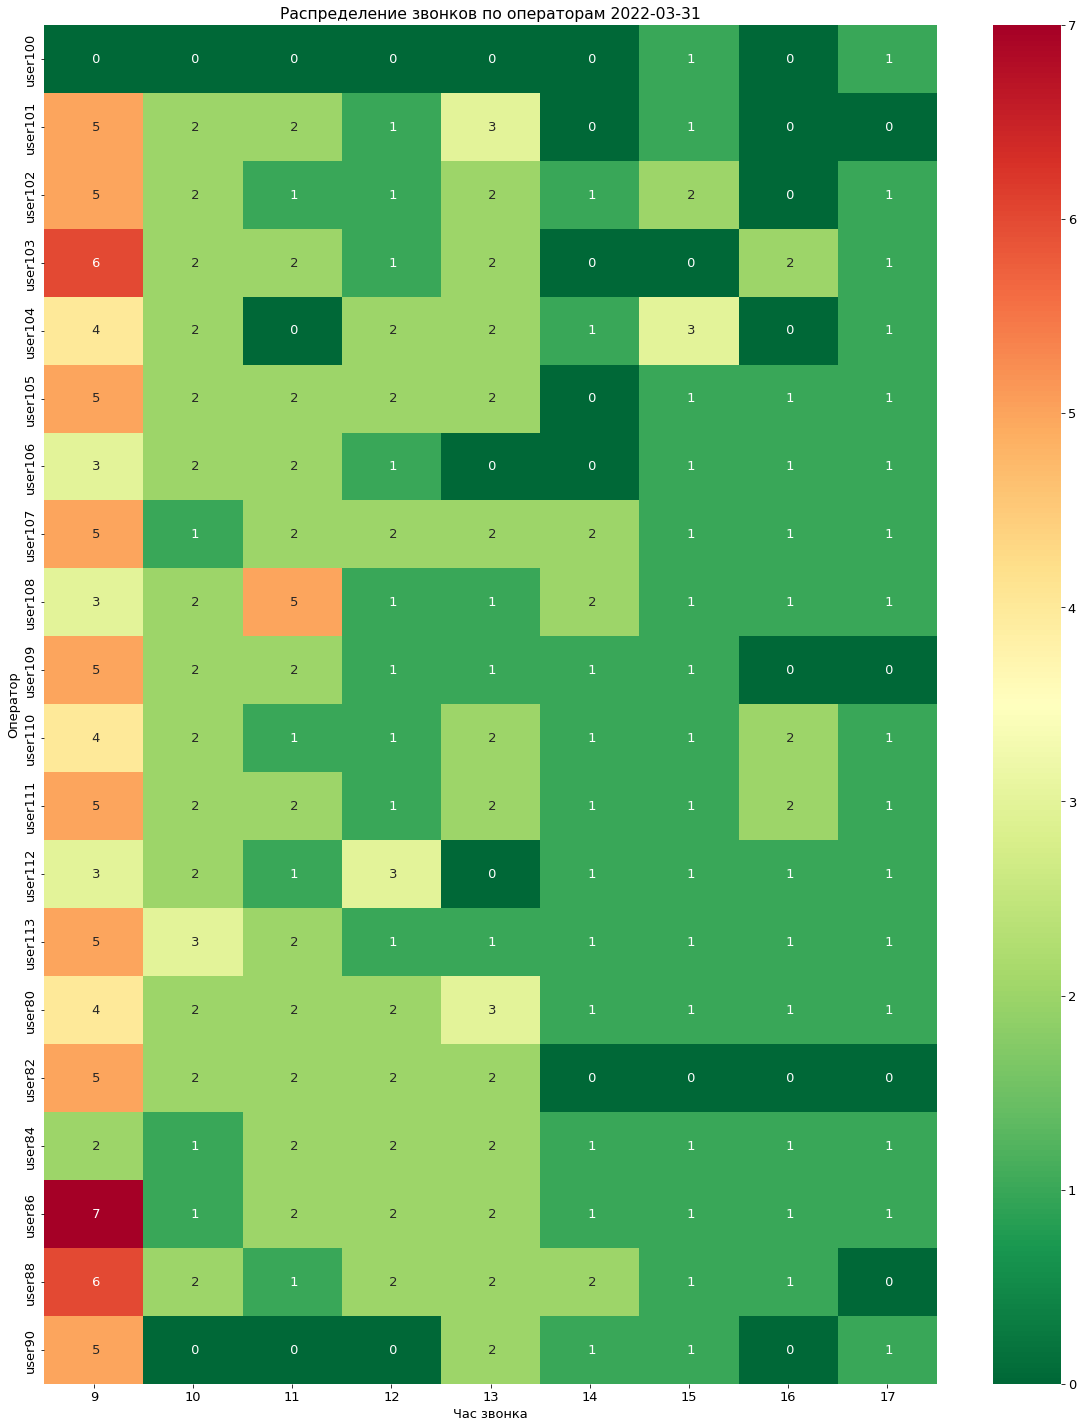

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

stress_on_oper =  df_specific_day[(df_specific_day['Оператор']!='user8') & (df_specific_day['Оператор']!='user9')& (df_specific_day['Оператор']!='Не определен') & (df_specific_day['Оператор']!='--')]

f = plt.figure(figsize=(20,25))
heatmap_plot = sns.heatmap(pd.crosstab(stress_on_oper['Оператор'], stress_on_oper['Час звонка']),annot=True,cmap="RdYlGn_r",fmt="2")
plt.title('Распределение звонков по операторам '+ str(reporting_date))

plt.show()

### Распределение звонков по операторам на втором домене

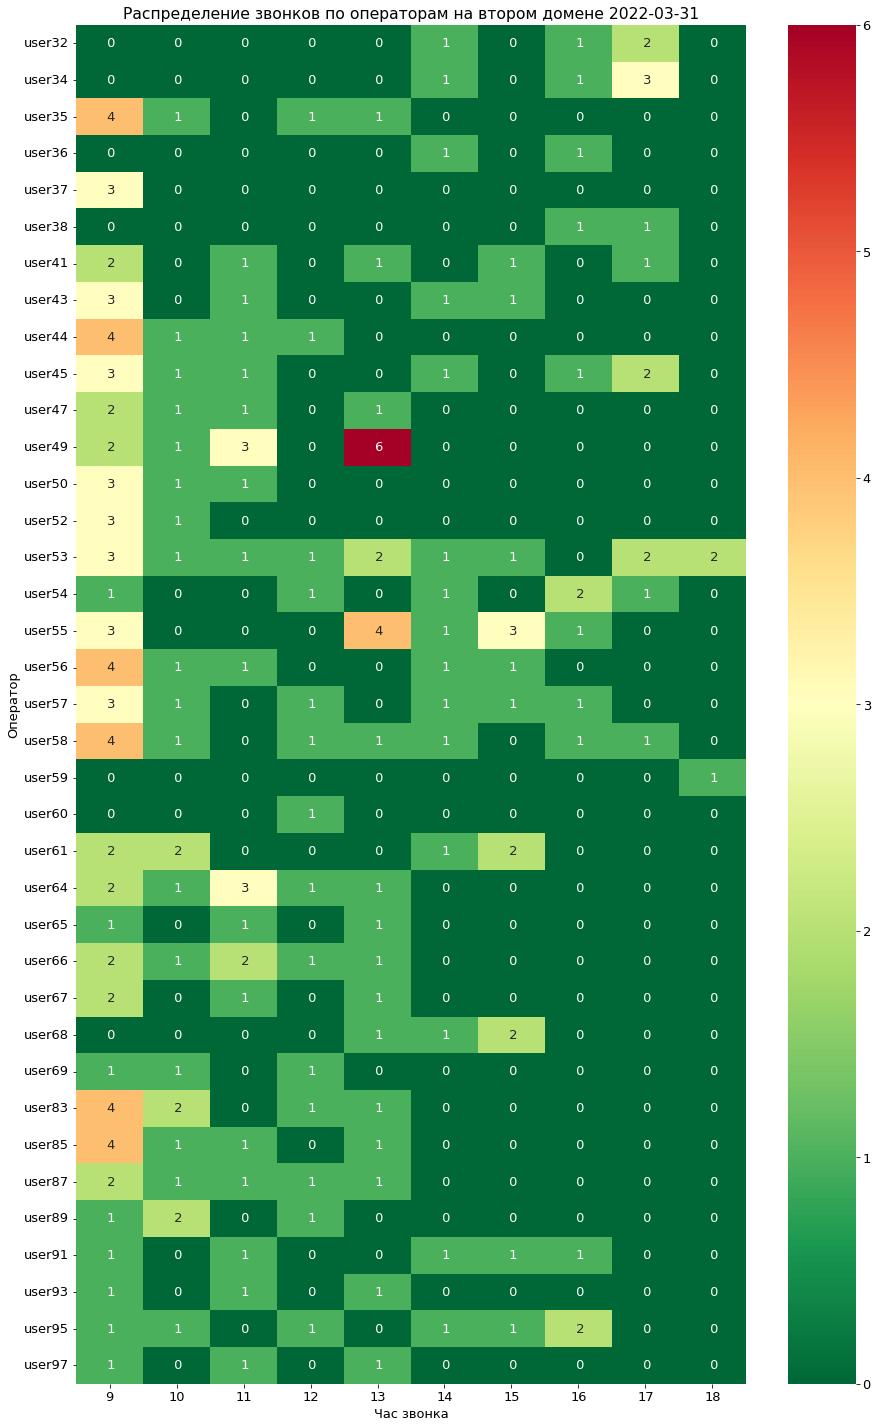

In [62]:
stress_on_oper2 =  df_specific_day2[(df_specific_day2['Оператор']!='user8') & (df_specific_day2['Оператор']!='user9') & (df_specific_day2['Оператор']!='Не определен') & (df_specific_day2['Оператор']!='--')]

f2 = plt.figure(figsize=(15,25))
heatmap_plot2 = sns.heatmap(pd.crosstab(stress_on_oper2['Оператор'], stress_on_oper2['Час звонка']),annot=True,cmap="RdYlGn_r",fmt="2")
plt.title('Распределение звонков по операторам на втором домене '+ str(reporting_date2))

plt.show()

### Обшее количество недозвонов по часам за конкретную дату по первому домену

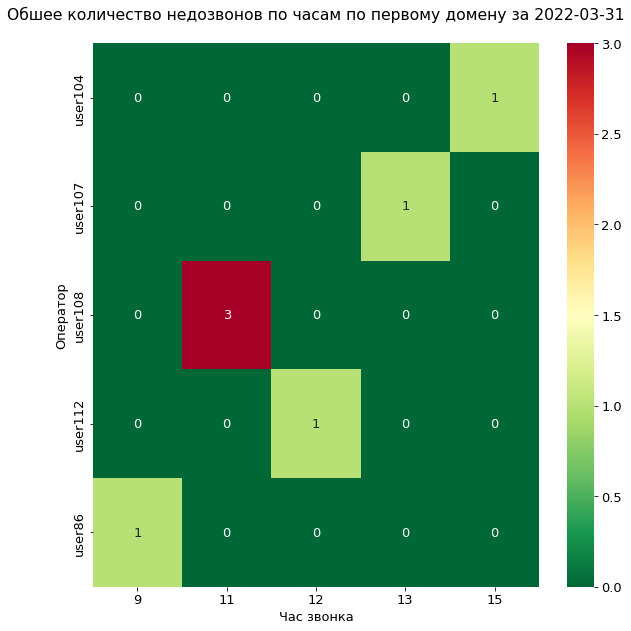

In [63]:
didnot_calls = df_specific_day[(df_specific_day['Оператор'] == '--') | (df_specific_day['Статус звонка'] == 'Не дождался')]

print_didnot_calls = didnot_calls[['Время звонка', 'Номер телефона', 'Время ожидания звонка', 'Оператор']].copy()
print_didnot_calls.to_excel(f"Обшее количество недозвонов по первому домену {reporting_date2}.xlsx")


f = plt.figure(figsize=(10,10))

heatmap_plot = sns.heatmap(pd.crosstab(didnot_calls['Оператор'], didnot_calls['Час звонка']),annot=True,cmap="RdYlGn_r",fmt="1")
plt.title('Обшее количество недозвонов по часам по первому домену за '+ str(reporting_date2) + '\n')

plt.show()

### Обшее количество недозвонов по часам за конкретную дату по второму домену

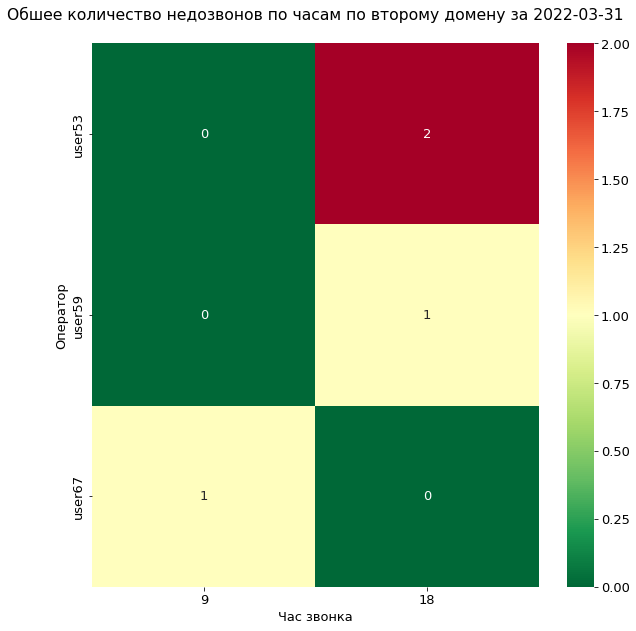

In [64]:
didnot_calls2 = df_specific_day2[(df_specific_day2['Оператор'] == '--') | (df_specific_day2['Статус звонка'] == 'Не дождался')]

print_didnot_calls2 = didnot_calls2[['Время звонка', 'Номер телефона', 'Группа', 'Время ожидания звонка', 'Оператор']].copy()
print_didnot_calls2.to_excel(f"Обшее количество недозвонов по второму домену {reporting_date2}.xlsx")

f = plt.figure(figsize=(10,10))

heatmap_plot = sns.heatmap(pd.crosstab(didnot_calls2['Оператор'], didnot_calls2['Час звонка']),annot=True,cmap="RdYlGn_r",fmt="1")
plt.title('Обшее количество недозвонов по часам по второму домену за '+ str(reporting_date2) + '\n')

plt.show()

### Распределение звонков по операторам за конкретную дату по первому домену

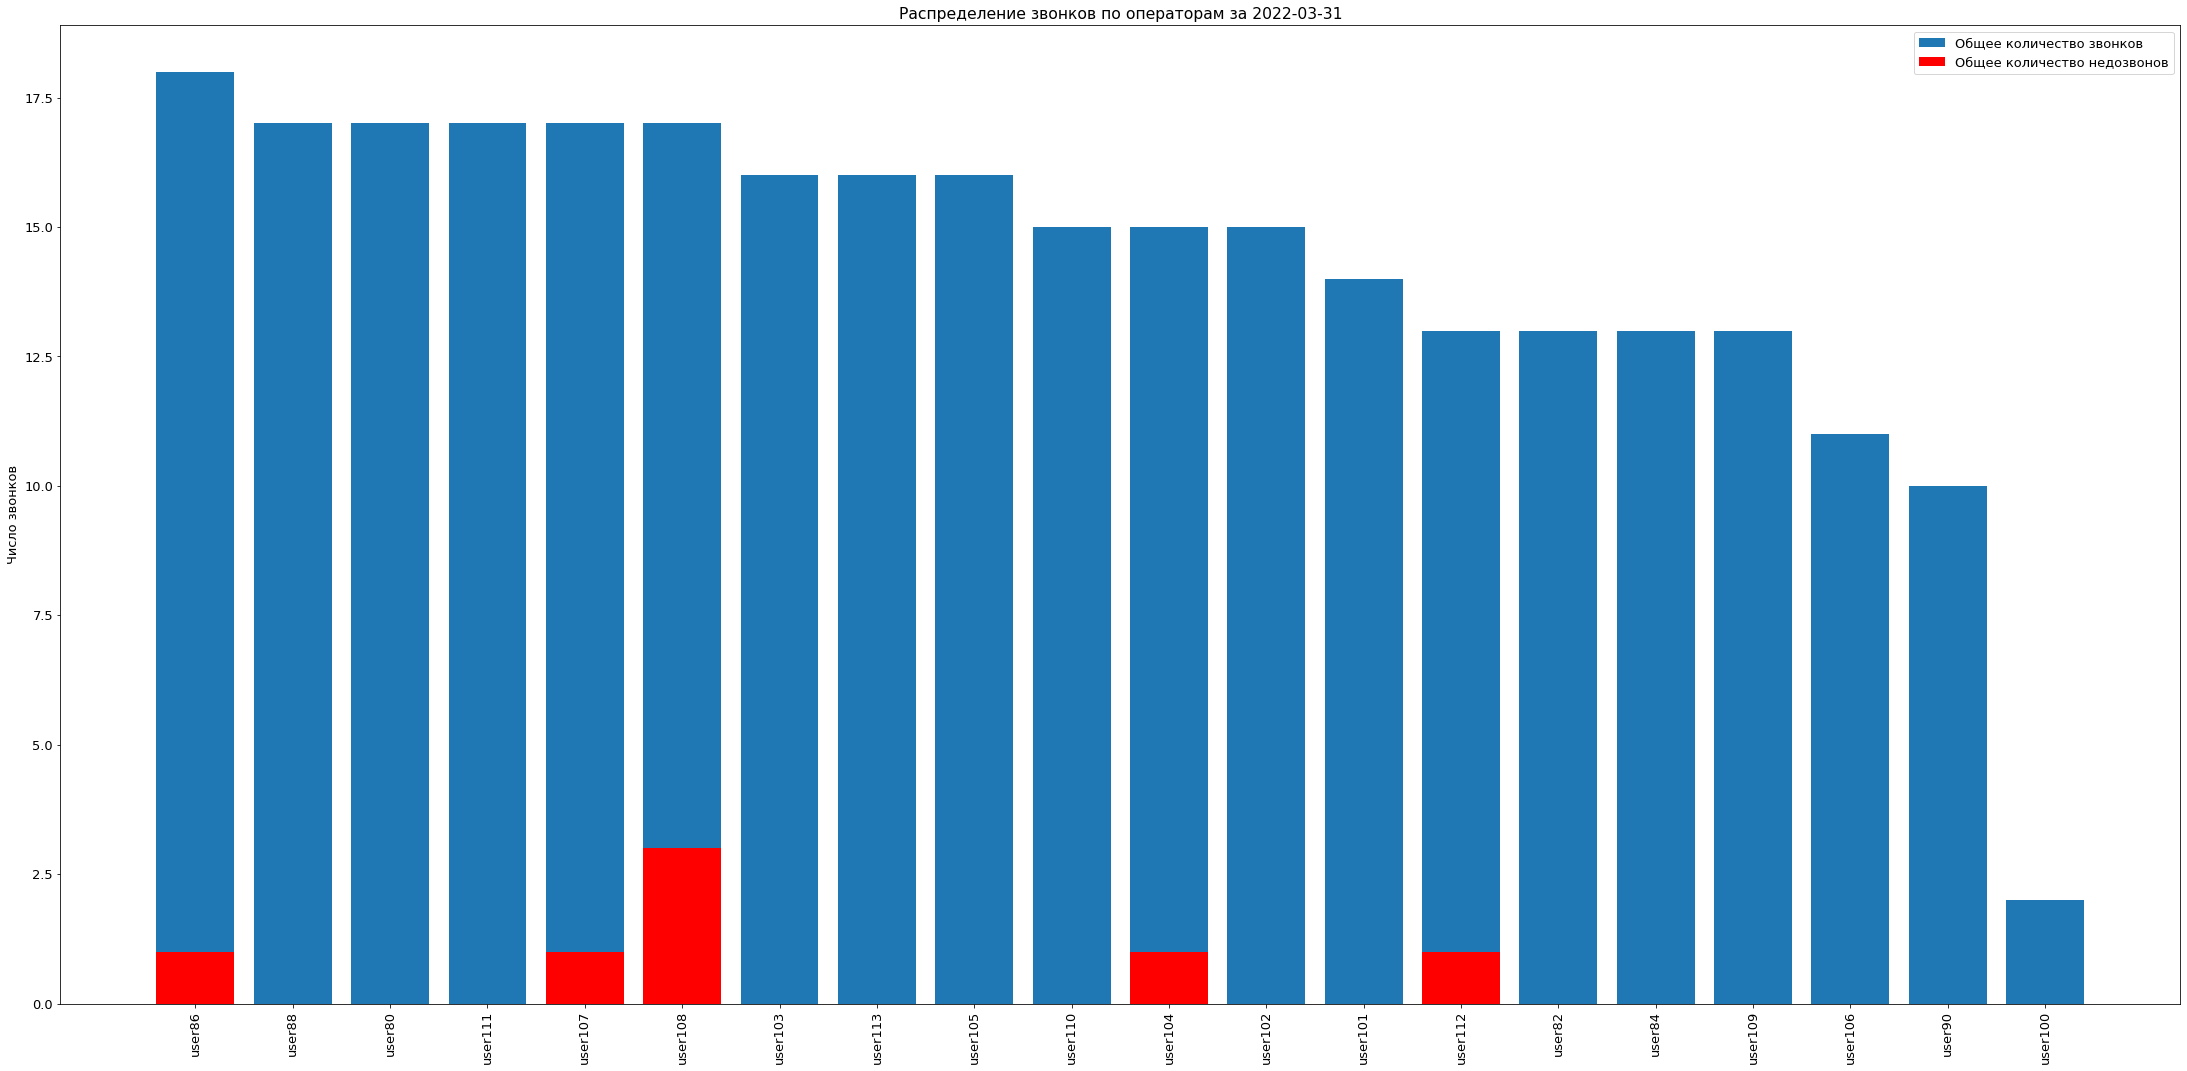

In [65]:
all_calls = stress_on_oper.groupby('Оператор')['Час звонка'].count().reset_index(name="Число звонков").sort_values('Число звонков',ascending=False)

didnot_calls_oper = stress_on_oper[stress_on_oper['Статус звонка']=='Не дождался'].groupby('Оператор')['Час звонка'].count().reset_index(name="Число звонков")

f = plt.figure(figsize=(38,18))
plt.bar(all_calls['Оператор'], all_calls['Число звонков'],label='Общее количество звонков')
plt.bar(didnot_calls_oper['Оператор'], didnot_calls_oper['Число звонков'],label='Общее количество недозвонов',color='red')

plt.ylabel('Число звонков')
plt.title('Распределение звонков по операторам за '+ str(reporting_date))

plt.rcParams.update({'font.size': 13})
plt.gca().xaxis.set_tick_params(rotation = 90) 
plt.legend()
plt.show()

### Распределение звонков по операторам за конкретную дату по второму домену

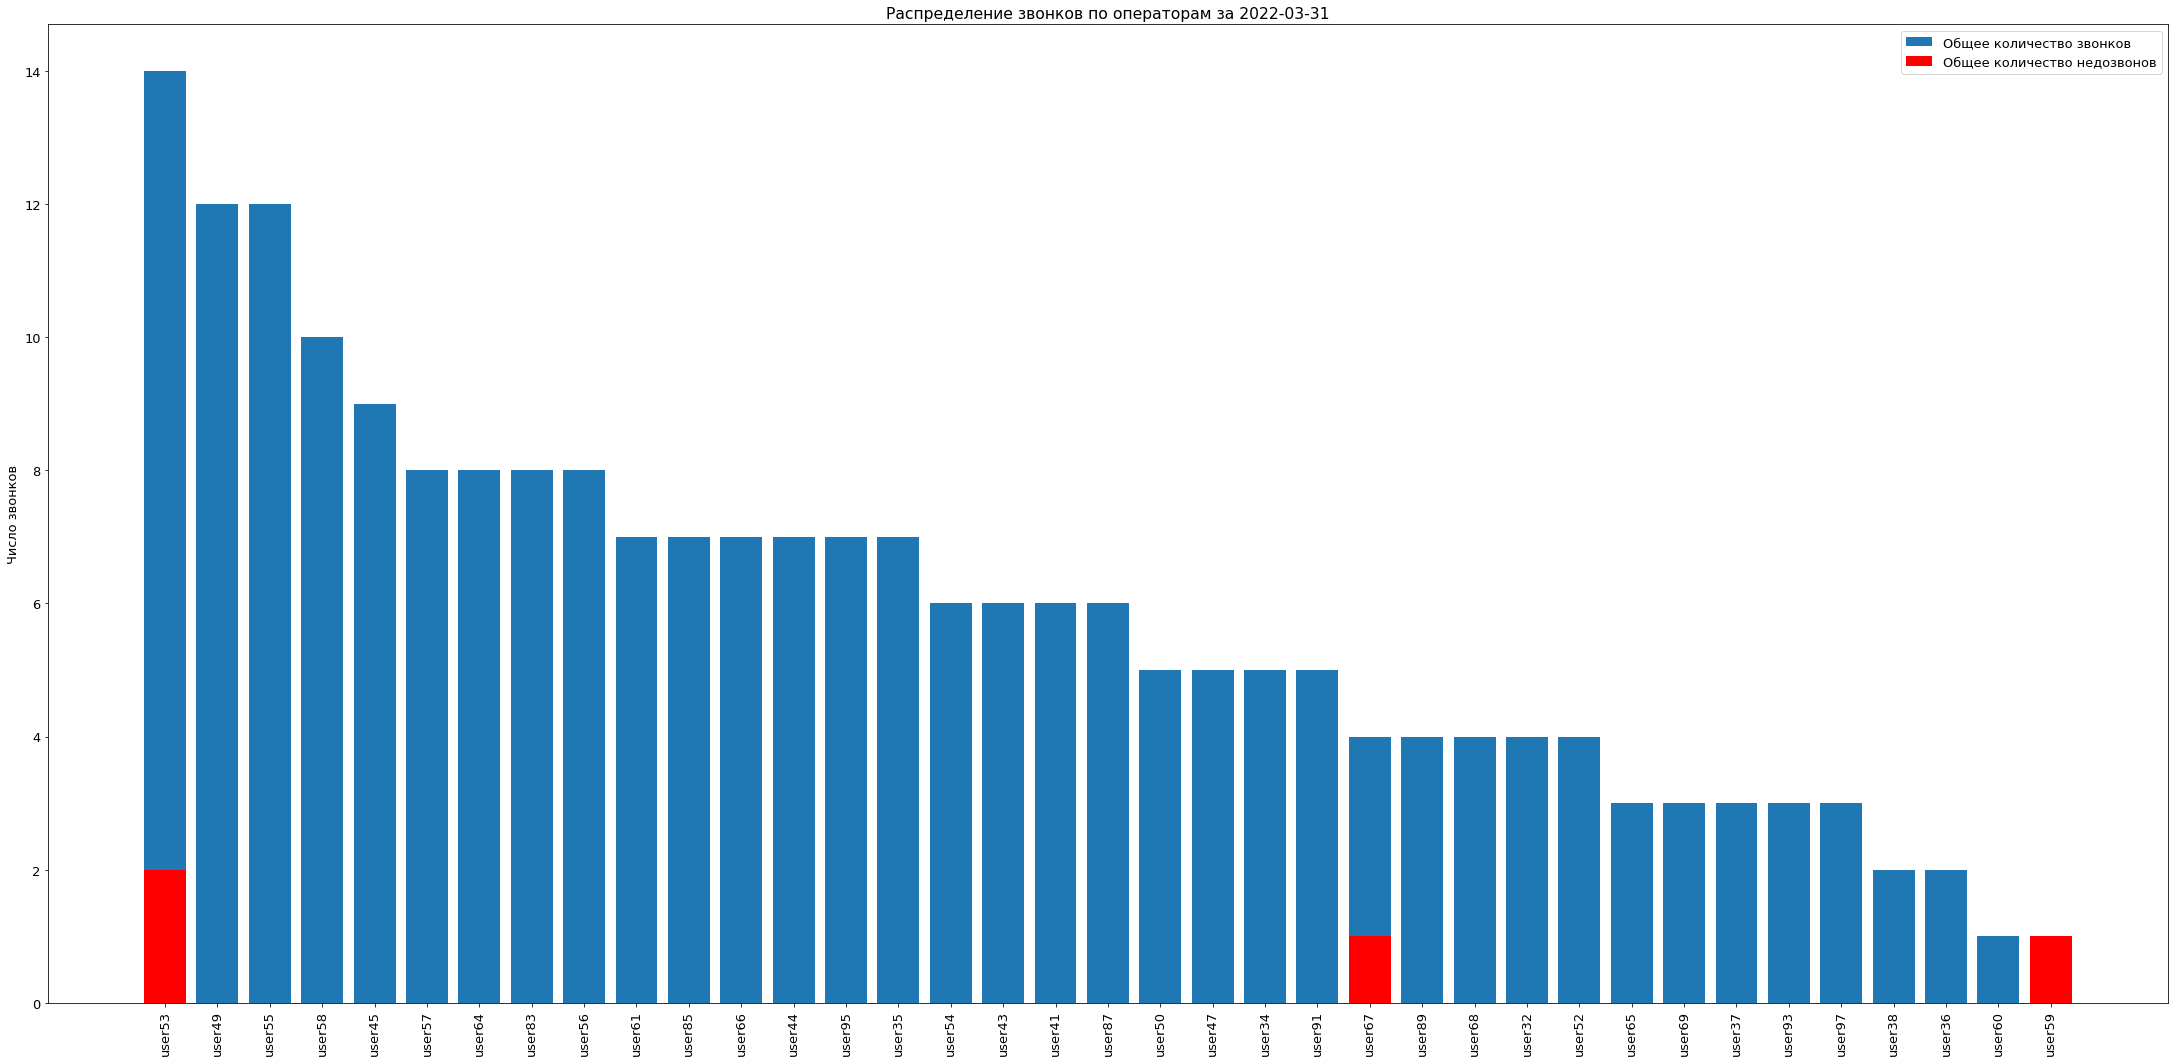

In [66]:
all_calls2 = stress_on_oper2.groupby('Оператор')['Час звонка'].count().reset_index(name="Число звонков").sort_values('Число звонков',ascending=False)

didnot_calls2_oper = stress_on_oper2[stress_on_oper2['Статус звонка']=='Не дождался'].groupby('Оператор')['Час звонка'].count().reset_index(name="Число звонков")

f = plt.figure(figsize=(38,18))
plt.bar(all_calls2['Оператор'], all_calls2['Число звонков'],label='Общее количество звонков')
plt.bar(didnot_calls2_oper['Оператор'], didnot_calls2_oper['Число звонков'],label='Общее количество недозвонов',color='red')

plt.ylabel('Число звонков')
plt.title('Распределение звонков по операторам за '+ str(reporting_date2))

plt.rcParams.update({'font.size': 13})
plt.gca().xaxis.set_tick_params(rotation = 90) 
plt.legend()
plt.show()

### Общее количество звонков на втором домене в разрезе групп на отчётную дату 

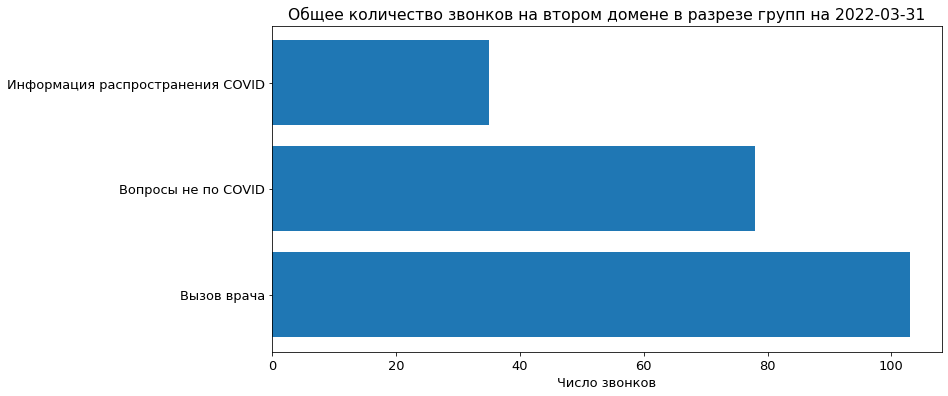

In [67]:
# Общее количество звонков на втором домене в разрезе групп
group_calls2=df_specific_day2.groupby('Группа')['Час звонка'].count().reset_index(name="Число звонков").sort_values(by='Число звонков',ascending=False)


f = plt.figure(figsize=(12,6))
plt.barh(group_calls2['Группа'], group_calls2['Число звонков'],label='Общее количество звонков')

plt.xlabel('Число звонков')
plt.title(f'Общее количество звонков на втором домене в разрезе групп на {reporting_date2}')

plt.rcParams.update({'font.size': 13})
plt.show()

### Общее количество звонков на втором домене в разрезе групп на отчётную дату (Круговая диаграмма)

Общее количество звонков на втором домене в разрезе групп на 2022-03-31


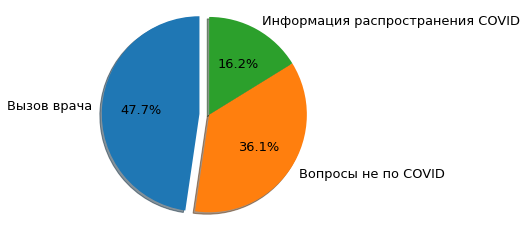

In [68]:
vals = group_calls2['Число звонков']
labels = group_calls2['Группа']
explode = tuple([0.1 if x == 0 else 0 for x in range(len(labels))])
fig, ax = plt.subplots()

ax.pie(vals, labels=labels, explode=explode, autopct='%1.1f%%',shadow=True, startangle=90)
ax.axis("equal")
print(f'Общее количество звонков на втором домене в разрезе групп на {reporting_date2}')

### Динамика звонков по часам за конкретную дату на первом домене


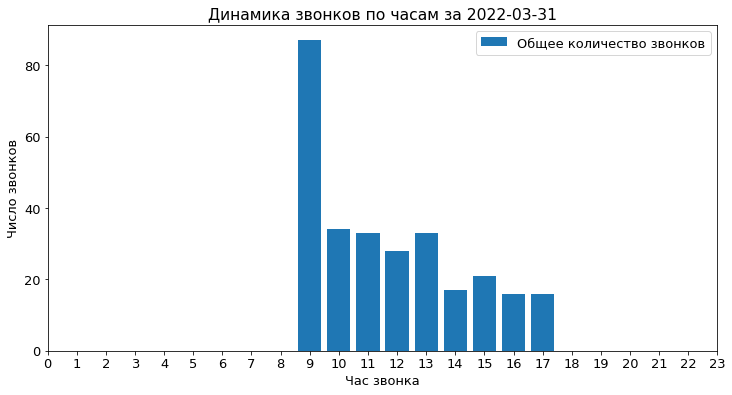

In [69]:
count_calls = df_specific_day.groupby('Час звонка')['Дата звонка'].count().reset_index(name="Число звонков")
f = plt.figure(figsize=(12,6))
plt.bar(count_calls['Час звонка'], count_calls['Число звонков'],label='Общее количество звонков')

plt.xlabel('Час звонка')
plt.ylabel('Число звонков')
plt.title(f'Динамика звонков по часам за {reporting_date}')

plt.rcParams.update({'font.size': 13})
plt.xticks(np.arange(0,24,1))
plt.legend()
plt.show()

### Динамика звонков по часам за конкретную дату на втором домене


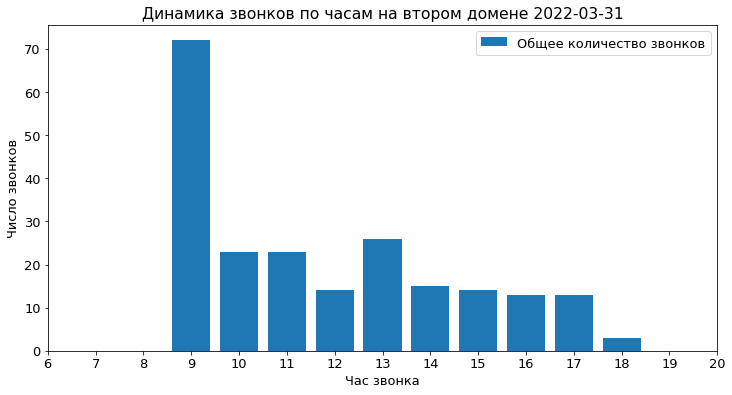

In [70]:
count_calls2 = df_specific_day2.groupby('Час звонка')['Дата звонка'].count().reset_index(name="Число звонков")
f = plt.figure(figsize=(12,6))
plt.bar(count_calls2['Час звонка'], count_calls2['Число звонков'],label='Общее количество звонков')

plt.xlabel('Час звонка')
plt.ylabel('Число звонков')
plt.title(f'Динамика звонков по часам на втором домене {reporting_date2}')

plt.rcParams.update({'font.size': 13})
plt.xticks(np.arange(6,21,1))
plt.legend()
plt.show()

In [71]:
tmp=total_all_days[(total_all_days['Дата звонка']>=dt.date(2021,4,1)) & (total_all_days['Дата звонка']<=dt.date(2021,4,30))].groupby('Дата звонка')['Час звонка'].count().reset_index(name="Число звонков")
tmp2=total_all_days [ (total_all_days['Статус звонка']!='Не дождался') & (total_all_days['Дата звонка']>=dt.date(2021,4,1)) & (total_all_days['Дата звонка']<=dt.date(2021,4,30))].groupby('Дата звонка')['Час звонка'].count().reset_index(name="Число звонков")
Total = tmp2['Число звонков'].sum()

print(tmp2)
print(Total)


   Дата звонка  Число звонков
0   2021-04-01           1021
1   2021-04-02            841
2   2021-04-03            216
3   2021-04-04            126
4   2021-04-05           1555
5   2021-04-06           1061
6   2021-04-07           1153
7   2021-04-08            884
8   2021-04-09            964
9   2021-04-10            154
10  2021-04-11             85
11  2021-04-12           1414
12  2021-04-13            851
13  2021-04-14            581
14  2021-04-15            618
15  2021-04-16            686
16  2021-04-17            105
17  2021-04-18             81
18  2021-04-19           1232
19  2021-04-20            755
20  2021-04-21            725
21  2021-04-22            556
22  2021-04-23            513
23  2021-04-24            131
24  2021-04-25             66
25  2021-04-26           1140
26  2021-04-27            956
27  2021-04-28            475
28  2021-04-29            369
29  2021-04-30            417
19731


# РОСТЕЛЕКОМ первый домен

In [72]:
# namesRT = glob.glob('/home/trinity/Anaconda code/Работа/Недозвоны/Ростелеком/*', recursive=True)
namesRT = glob.glob('../Недозвоны/Ростелеком/*', recursive=True)
contRT=[]
for i in range(len(namesRT)):
    
    date=re.search( r'[0-9]{4}-[0-9]{2}-[0-9]{2}', namesRT[i]).group()
    df_RT = pd.read_excel(namesRT[i],dtype={'Номер вызывающего': str})
    if (dt.datetime.strptime(date, "%Y-%m-%d")<dt.datetime(2021,4,22)):
        df_RT['Длительность']=df_RT['Длительность'].str.replace( ' мин.', '').str.replace(' сек.', '')        
        df_RT['Длительность']=df_RT['Длительность'].apply(lambda x: int(x.split(' ')[0])*60+int(x.split(' ')[1]) if len(x.split(' '))==2 else int(x.split(' ')[0]))
    else:
        df_RT['Длительность']=pd.to_timedelta(df_RT['Длительность'].astype('str'))
        df_RT['Длительность']=df_RT['Длительность'].apply(lambda x: x.total_seconds())
    df_RT=df_RT[df_RT['Длительность'] > 9]
    
    df_RT= df_RT[['Дата вызова','Время вызова','Номер вызывающего','Номер вызываемого', 'Первый ответивший', 'Статус', 'Длительность', 'Группа']]
    df_RT['Номер вызываемого']=df_RT['Номер вызываемого'].astype('str')
    df_RT['Время вызова']=df_RT['Время вызова'].apply(lambda x: dt.datetime.strptime(x, '%H:%M:%S'))
    df_RT['Дата вызова']=pd.to_datetime(df_RT['Дата вызова'])
    df_RT['День недели']=df_RT['Дата вызова'].apply(lambda x: x.weekday())
    df_RT['Час звонка']=df_RT['Время вызова'].dt.hour
    df_RT['Время вызова']=df_RT['Время вызова'].dt.time    
    contRT.append(df_RT)
    
total_all_days_RT = pd.concat(contRT,ignore_index=True)

total_all_days_RT = total_all_days_RT.rename(columns={'Первый ответивший': 'Оператор'})
total_all_days_RT['Группа']=total_all_days_RT['Группа'].replace({'Общая':'Медколледж','Консультация':'Облкомобразования'})
total_all_days_RT['Группа']=total_all_days_RT['Группа'].fillna('Не определена')
total_all_days_RT['Оператор']=total_all_days_RT['Оператор'].replace({' ':'Не определен'})

total_all_days_RT = total_all_days_RT.drop(total_all_days_RT[(total_all_days_RT['Группа'] =='Не определена') & (total_all_days_RT['Статус'] =='пропущенный')].index)
total_all_days_RT = total_all_days_RT.drop(total_all_days_RT[(total_all_days_RT['Длительность'] < 120) & (total_all_days_RT['Статус'] =='пропущенный')].index)

total_all_days_RT['Номер вызывающего']=total_all_days_RT['Номер вызывающего'].str.replace(' ', '')
total_all_days_RT['Номер вызываемого']=total_all_days_RT['Номер вызываемого'].str.replace(' ', '')
hospitals=pd.read_excel('Переадресация телефонов.xlsx')
total_all_days_RT=total_all_days_RT.merge(hospitals, how = 'left', left_on='Номер вызывающего', right_on='Единый номер')

total_all_days_RT['Наименование учреждения'] = total_all_days_RT['Наименование учреждения'].str.replace('Государственное учреждение здравоохранения','ГУЗ')
total_all_days_RT['Наименование учреждения'] = total_all_days_RT['Наименование учреждения'].str.replace('Государственное бюджетное учреждение здравоохранения','ГБУЗ') 
total_all_days_RT['Наименование учреждения'] = total_all_days_RT['Наименование учреждения'].str.replace('Клиническая больница скорой медицинской помощи','КБСМП')
total_all_days_RT['Наименование учреждения'] = total_all_days_RT['Наименование учреждения'].str.replace('клиническая поликлиника','КП')

C:\Users\AdminIS\AppData\Local\Temp/ipykernel_10280/3376279938.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df_RT['Длительность']=df_RT['Длительность'].str.replace( ' мин.', '').str.replace(' сек.', '')


In [73]:
# Определение зон

def give_missed_calls_zone(percentage):
    zone = ''
    if (percentage >= 15):
        zone = 'красная'
    elif ( 5 < percentage < 15):
        zone = 'желтая'
    else:
        zone = 'зеленая'
    return zone


def give_mean_wait_zone(time_wait):
    zone = ''
    if (time_wait > 10):
        zone = 'красная'
    elif ( 2 < time_wait <= 10):
        zone = 'желтая'
    else:
        zone = 'зеленая'
    return zone

# Cчитаем отчёт для ЕА
def report_for_EA(df_VMK, df_RT):
    # дата отчёта
    report_data = df_VMK['Дата звонка'].values[0].strftime("%d.%m.%Y")
    # всего звонков
    all_calls = df_RT[df_RT['Номер вызываемого']=='78442325552'].shape[0]
    # количество неотвеченных
    missed_calls_count = df_RT[(df_RT['Статус']=='пропущенный') & (df_RT['Номер вызываемого']=='78442325552')].shape[0]   
    # Рассчитываем процент недозвонов    
    percentage_missed = np.round(missed_calls_count/all_calls * 100, 2)
    missed_calls_zone = give_missed_calls_zone(percentage_missed)
    # Рассчитываем среднее время ожидания
    mean_wait = np.round(df_VMK['Время ожидания'].mean(),3)
    mean_wait_zone = give_mean_wait_zone(mean_wait)
        
    print(f"""Информация по вызовам на "122" за {report_data}:
Всего вызовов: {all_calls}
Неотвеченных вызовов: {missed_calls_count} ( {str(percentage_missed).replace('.',',')}%, {missed_calls_zone} зона)
Среднее время ожидания: {str(mean_wait).replace('.',',')} мин. ({mean_wait_zone} зона)
""")

In [74]:
# def rename_df_RT(dataframeRT):
#     dataframeRT = dataframeRT.rename(columns={'Первый ответивший': 'Оператор'})
#     dataframeRT['Группа']=dataframeRT['Группа'].fillna('Не определена')
#     dataframeRT['Оператор']=dataframeRT['Оператор'].replace({' ':'Не определен'})

#     dataframeRT = dataframeRT.drop(dataframeRT[(dataframeRT['Группа'] =='Не определена') & (dataframeRT['Статус'] =='пропущенный')].index)
#     dataframeRT = dataframeRT.drop(dataframeRT[(dataframeRT['Длительность'] < 120) & (dataframeRT['Статус'] =='пропущенный')].index)
#     dataframeRT['Номер вызывающего']=dataframeRT['Номер вызывающего'].str.replace(' ', '')
#     dataframeRT['Номер вызываемого']=dataframeRT['Номер вызываемого'].str.replace(' ', '')


#     hospitals=pd.read_excel('Переадресация телефонов.xlsx')
#     dataframeRT=dataframeRT.merge(hospitals, how = 'left', left_on='Номер вызывающего', right_on='Единый номер')

#     dataframeRT['Наименование учреждения'] = dataframeRT['Наименование учреждения'].str.replace('Государственное учреждение здравоохранения','ГУЗ')
#     dataframeRT['Наименование учреждения'] = dataframeRT['Наименование учреждения'].str.replace('Государственное бюджетное учреждение здравоохранения','ГБУЗ') 
#     dataframeRT['Наименование учреждения'] = dataframeRT['Наименование учреждения'].str.replace('Клиническая больница скорой медицинской помощи','КБСМП')
#     dataframeRT['Наименование учреждения'] = dataframeRT['Наименование учреждения'].str.replace('клиническая поликлиника','КП')
#     return dataframeRT
# total_all_days_RT = rename_df_RT(total_all_days_RT)
# #total_all_days_RT = total_all_days_RT[total_all_days_RT['Дата вызова'] == '2022-02-10'] 
# total_all_days_RT
# # x = total_all_days_RT['Дата вызова'].values[0]
# # print(x)
# # print(type(x))
# # total_all_days_RT

##### 

In [75]:
def calculate_statistics_RT(dataframe):
    all_calls_count=dataframe.shape[0]
    all_calls_5552_count=dataframe[dataframe['Номер вызываемого']=='78442325552'].shape[0]
    all_calls_5554_count=dataframe[dataframe['Номер вызываемого']=='78442325554'].shape[0]
    missed_calls=dataframe[dataframe['Статус']=='пропущенный']
    missed_calls_count=missed_calls.shape[0]
    missed_calls_5552_count=missed_calls[missed_calls['Номер вызываемого']=='78442325552'].shape[0]
    missed_calls_5554_count=missed_calls[missed_calls['Номер вызываемого']=='78442325554'].shape[0]
    
    hospital_calls=dataframe[dataframe['Наименование учреждения'].isnull()==False]
    hospital_calls_count=hospital_calls.shape[0]
    hospital_calls_count_5552=hospital_calls[hospital_calls['Номер вызываемого']=='78442325552'].shape[0]
    hospital_calls_count_5554=hospital_calls[hospital_calls['Номер вызываемого']=='78442325554'].shape[0]
    
    print('По выгрузке Ростелекома: неотвеченных вызовов - {0} %'.format(np.round(missed_calls_5552_count/all_calls_5552_count*100,2)))
    print('Всего вызовов – {0}, неотвеченных – {1} (отфильтровано менее 120 сек, а также по группе "Не определена").'.format(all_calls_5552_count, missed_calls_5552_count))
      
    


In [76]:
from datetime import datetime
def calculate_statistics_WMK(dataframe):      
    # Рассчитываем максимальнок время ожидание
    max_wait_df = dataframe[dataframe['Время ожидания']==dataframe['Время ожидания'].max()]
    group_with_max_wait = max_wait_df['Группа'].values[0]
    oper__with_max_wait = max_wait_df['Оператор'].values[0]    
    max_wait=np.round(dataframe['Время ожидания'].max(),1)
    time_with_max_wait = max_wait_df['Время звонка'].values[0]    
    report_data = dataframe['Дата звонка'].values[0].strftime("%d.%m.%Y")
    report_data_time = datetime.now().strftime("%H:%M")
    
    print(f"""
Информация по вызовам по состоянию на {report_data_time} за {report_data}.
Максимальное время ожидания за сутки (мин): {max_wait} (Оператор: {oper__with_max_wait}, Группа: {group_with_max_wait}, Время звонка: {time_with_max_wait}))
    """)
    


# Выбор отчётной даты

In [77]:
dayRT=dt.datetime(2022,3,31)

# Создаём датафрейм для первого домена Ростелеком за определенную дату
df_specific_day_RT = total_all_days_RT[total_all_days_RT['Дата вызова'] == dayRT]

### Считаем статистику по первому домену

In [78]:
calculate_statistics_WMK(df_specific_day)
calculate_statistics_RT(df_specific_day_RT)
#total_all_days_RT[(total_all_days_RT['Номер вызываемого']=='78442325552') & (total_all_days_RT['Дата вызова']==dayRT) & (total_all_days_RT['Статус']=='пропущенный')]

table_RT=total_all_days_RT[(total_all_days_RT['Номер вызываемого']=='78442325552') & (total_all_days_RT['Дата вызова']==dayRT) & (total_all_days_RT['Статус']=='пропущенный')]
table_RT.to_excel("Неотвеченные.xlsx")


Информация по вызовам по состоянию на 08:49 за 31.03.2022.
Максимальное время ожидания за сутки (мин): 0.8 (Оператор: user109, Группа: Медколледж, Время звонка: 11:17:31))
    
По выгрузке Ростелекома: неотвеченных вызовов - 0.0 %
Всего вызовов – 291, неотвеченных – 0 (отфильтровано менее 120 сек, а также по группе "Не определена").


### Распределение звонков по операторам

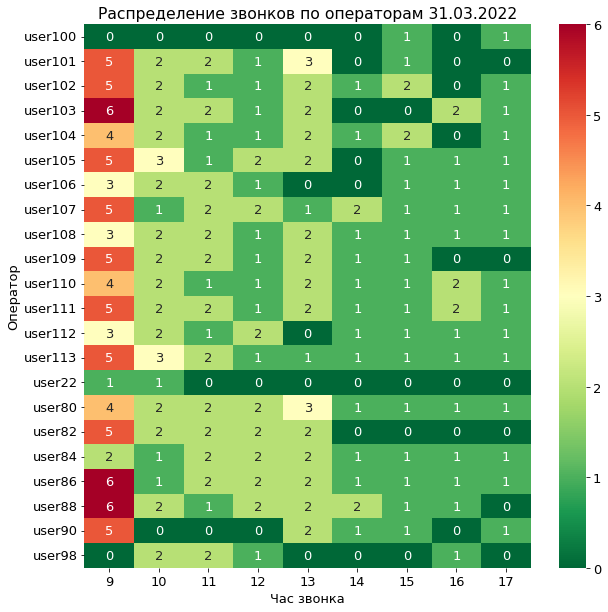

In [79]:
################################################################################################
tmp = df_specific_day_RT[(df_specific_day_RT['Номер вызываемого'] =='78442325552') & (df_specific_day_RT['Оператор']!='user8') & (df_specific_day_RT['Оператор']!='user9')]

f = plt.figure(figsize=(10,10))
heatmap_plot = sns.heatmap(pd.crosstab(tmp['Оператор'], tmp['Час звонка']),annot=True,cmap="RdYlGn_r",fmt="1")
plt.title('Распределение звонков по операторам '+day.strftime('%d.%m.%Y'))

plt.show()


### Обшее количество недозвонов по часам

In [80]:
if tmp[tmp['Оператор']=='Не определен'].empty:
    print("Нет пропущенных звонков")        
else:        
    temp2 = tmp[tmp['Оператор']=='Не определен']
    f = plt.figure(figsize=(10,1))
    heatmap_plot = sns.heatmap(pd.crosstab(temp2['Оператор'], temp2['Час звонка']),annot=True,cmap="RdYlGn_r",fmt="1")
    plt.title('Обшее количество недозвонов по часам за '+day.strftime('%d.%m.%Y' + '\n'))
    plt.show('Не определен')

Нет пропущенных звонков


### Общее количество звонков на первом домене в разрезе групп

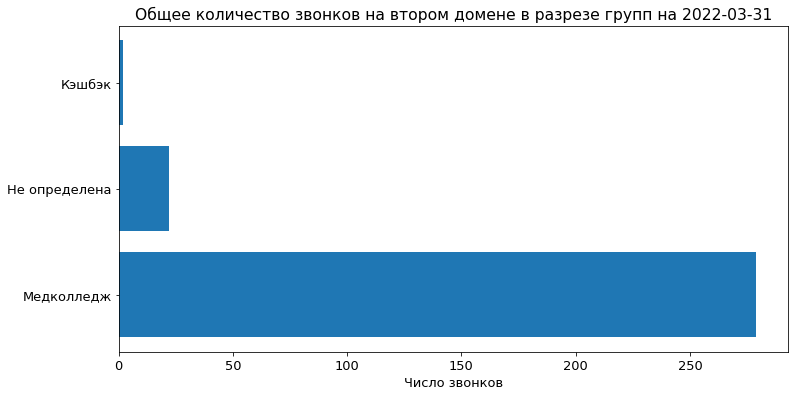

In [81]:
group_calls_RT=df_specific_day_RT.groupby('Группа')['Час звонка'].count().reset_index(name="Число звонков").sort_values(by='Число звонков',ascending=False)


f = plt.figure(figsize=(12,6))
plt.barh(group_calls_RT['Группа'], group_calls_RT['Число звонков'],label='Общее количество звонков')

plt.xlabel('Число звонков')
plt.title(f'Общее количество звонков на втором домене в разрезе групп на {dayRT.date()}')

plt.rcParams.update({'font.size': 13})
plt.show()

### Общее количество звонков на первом домене в разрезе групп (Круговая диаграмма)

Общее количество звонков на первом домене в разрезе групп на 2022-03-31


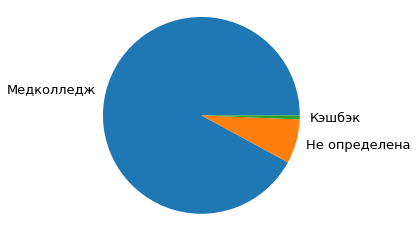

In [82]:
vals = group_calls_RT['Число звонков']
labels = group_calls_RT['Группа']

fig, ax = plt.subplots()
ax.pie(vals, labels=labels)
ax.axis("equal")
print(f'Общее количество звонков на первом домене в разрезе групп на {dayRT.date()}')

### Выгрузка по успешным звонкам за период

In [86]:
start_RT = '2022-01-01'
end_RT = '2022-03-31'
tmp_RT=total_all_days_RT[(total_all_days_RT['Статус']=='успешный') & (total_all_days_RT['Дата вызова']>=pd.to_datetime(start_RT)) & (total_all_days_RT['Дата вызова']<=pd.to_datetime(end_RT))].groupby('Дата вызова')['Время вызова'].count().reset_index(name="Число звонков")
Total = tmp_RT['Число звонков'].sum()
tmp_RT.to_excel("Успешные звонки.xlsx")
print(f'Всего звонков: {Total}')
tmp_RT

Всего звонков: 112959


,Дата вызова,Число звонков
0,2022-01-01,58
1,2022-01-02,115
2,2022-01-03,160
3,2022-01-04,168
4,2022-01-05,159
...,...,...
82,2022-03-26,119
83,2022-03-28,446
84,2022-03-29,327
85,2022-03-30,355


### Всего звонков

In [84]:
start_RT = '2022-01-27'
end_RT = '2022-01-31'
tmp_RT=total_all_days_RT[(total_all_days_RT['Дата вызова']>=pd.to_datetime(start_RT)) & (total_all_days_RT['Дата вызова']<=pd.to_datetime(end_RT))].groupby('Дата вызова')['Время вызова'].count().reset_index(name="Число звонков")
Total = tmp_RT['Число звонков'].sum()
tmp_RT.to_excel("Всего звонков.xlsx")
print(f'Всего звонков: {Total}')
tmp_RT

Всего звонков: 12299


,Дата вызова,Число звонков
0,2022-01-27,2255
1,2022-01-28,2291
2,2022-01-29,1293
3,2022-01-30,1672
4,2022-01-31,4788


## Отчёт для ЕА


In [85]:
report_for_EA(df_specific_day, df_specific_day_RT)

Информация по вызовам на "122" за 31.03.2022:
Всего вызовов: 291
Неотвеченных вызовов: 0 ( 0,0%, зеленая зона)
Среднее время ожидания: 0,121 мин. (зеленая зона)

